In [ ]:
# @title ###### Licensed to the Apache Software Foundation (ASF), Version 2.0 (the "License")

# Licensed to the Apache Software Foundation (ASF) under one
# or more contributor license agreements. See the NOTICE file
# distributed with this work for additional information
# regarding copyright ownership. The ASF licenses this file
# to you under the Apache License, Version 2.0 (the
# "License"); you may not use this file except in compliance
# with the License. You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing,
# software distributed under the License is distributed on an
# "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
# KIND, either express or implied. See the License for the
# specific language governing permissions and limitations
# under the License

# Use Apache Beam for Anomaly Detection on Batch and Streaming Data (Z-Score)
This notebook demonstrates how to perform anomaly detection on batch and streaming data using the `AnomalyDetection` PTransform, a new feature introduced in Apache Beam 2.64.0.

We will first generate a synthetic dataset that incorporates various types of concept drift (changes in the underlying data distribution). This data will then be published to a Pub/Sub topic to simulate a real-time input stream. Our Beam pipeline will read from this topic, apply the `AnomalyDetection` PTransform with the Z-Score algorithm, and publish the detected anomalies to a second Pub/Sub topic. Finally, we will visualize the labeled data points in an animated plot.

## Preparation
To get started with this notebook, you'll need to install the Apache Beam Python SDK and its associated extras. Make sure your installation is version 2.64.0 or later.

In [1]:
! pip install apache_beam[interactive,gcp]>=2.64.0 --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython==7.34.0, but you have ipython 8.36.0 which is incompatible.
distributed 2024.12.1 requires cloudpickle>=3.0.0, but you have cloudpickle 2.2.1 which is incompatible.
dask 2024.12.1 requires cloudpickle>=3.0.0, but you have cloudpickle 2.2.1 which is incompatible.


To proceed, import the essential modules: matplotlib, numpy, pandas, Beam, and others as needed.

In [2]:
# Imports Required for the notebook
import json
import os
import random
import threading
import time
import warnings
from typing import Any
from typing import Iterable
from typing import Tuple

import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML, Javascript
from google.api_core import retry
from google.api_core.exceptions import AlreadyExists
from google.cloud import pubsub_v1
from google.cloud.exceptions import NotFound

import apache_beam as beam
from apache_beam.io.gcp.pubsub import PubsubMessage
from apache_beam.ml.anomaly.base import AnomalyResult
from apache_beam.ml.anomaly.base import AnomalyPrediction
from apache_beam.ml.anomaly.detectors.zscore import ZScore
from apache_beam.ml.anomaly.transforms import AnomalyDetection
from apache_beam.ml.anomaly.univariate.mean import IncSlidingMeanTracker
from apache_beam.ml.anomaly.univariate.stdev import IncSlidingStdevTracker
from apache_beam.options.pipeline_options import PipelineOptions

# Suppress logging warnings
os.environ["GRPC_VERBOSITY"] = "ERROR"
os.environ["GLOG_minloglevel"] = "2"
warnings.filterwarnings('ignore')

 Next, replace `<PROJECT_ID>` with your Google Cloud project ID.

In [4]:
# GCP-related constant are listed below

# GCP project id
PROJECT_ID = 'apache-beam-testing'  # @param {type:'string'}

SUFFIX = str(random.randint(0, 10000))

# Pubsub topic and subscription for retrieving input data
INPUT_TOPIC = 'anomaly-input-' + SUFFIX
INPUT_SUB = INPUT_TOPIC + '-sub'

# Pubsub topic and subscription for collecting output result
OUTPUT_TOPIC = 'anomaly-output-' + SUFFIX
OUTPUT_SUB = OUTPUT_TOPIC + '-sub'

The last preparation step needs to authenticate your Google account and authorize your Colab notebook to access Google Cloud Platform (GCP) resources associated with the project set above.

In [5]:
from google.colab import auth
auth.authenticate_user(project_id=PROJECT_ID)

## Batch Data

### Generating Synthetic Data with Outliers

In [8]:
# The size of a segment in the synthetic data set. Each segment represents
# a collection of data points generated from either a fixed distribution
# or a drift from one distribution to another.
# The idea is inspired by https://github.com/yixiaoma666/SCAR.
seg_size = 200

# The ratio of global outliers introduced in the synthetic data set.
outlier_ratio = 0.01

# Random seed
seed = 1234

np.random.seed(seed)

# starting from a fixed distribution
data = np.random.normal(loc=0, scale=1, size=seg_size)

# adding outliers
outlier_idx = np.random.choice(len(data), size=int(outlier_ratio * len(data)), replace = False)

for idx in outlier_idx:
    data[idx] = np.random.normal(loc=15, scale=1, size=1).item()

df = pd.Series(data, name='f1')

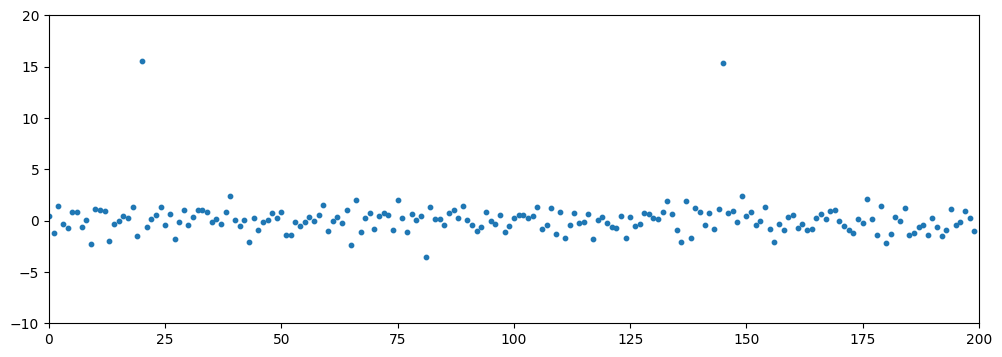

In [15]:
plt.figure(figsize=(12, 4))
plt.xlim(0, 200)
plt.ylim(-10, 20)
plt.scatter(x=range(len(df)), y=df, s=10)

### Run the Beam Pipeline on the Batch Data

In [17]:
options = PipelineOptions([])
with beam.Pipeline(options=options) as p:
    _ = (p | beam.Create(data)
        | "Convert to Rows" >> beam.Map(lambda x: beam.Row(f1=float(x))).with_output_types(beam.Row)
        | "Add key" >> beam.Map(lambda x: (0, x)).with_output_types(Tuple[int, beam.Row])
        | AnomalyDetection(ZScore(features=["f1"], sub_stat_tracker=IncSlidingMeanTracker(100),
                            stdev_tracker=IncSlidingStdevTracker(100)))
        | beam.LogElements()
    )

(0, AnomalyResult(example=Row(f1=0.47143516373249306), predictions=[AnomalyPrediction(model_id='ZScore', score=nan, label=-2, threshold=3, info='', source_predictions=None)]))
(0, AnomalyResult(example=Row(f1=-1.1909756947064645), predictions=[AnomalyPrediction(model_id='ZScore', score=nan, label=-2, threshold=3, info='', source_predictions=None)]))
(0, AnomalyResult(example=Row(f1=1.4327069684260973), predictions=[AnomalyPrediction(model_id='ZScore', score=1.5248610784612329, label=0, threshold=3, info='', source_predictions=None)]))
(0, AnomalyResult(example=Row(f1=-0.3126518960917129), predictions=[AnomalyPrediction(model_id='ZScore', score=0.4146369992972177, label=0, threshold=3, info='', source_predictions=None)]))
(0, AnomalyResult(example=Row(f1=-0.7205887333650116), predictions=[AnomalyPrediction(model_id='ZScore', score=0.7339768418339636, label=0, threshold=3, info='', source_predictions=None)]))
(0, AnomalyResult(example=Row(f1=0.8871629403077386), predictions=[AnomalyPredi

## Streaming Data

### Generating Synthetic Data with Concept Drift

In [ ]:
# The size of a segment in the synthetic data set. Each segment represents
# a collection of data points generated from either a fixed distribution
# or a drift from one distribution to another.
# The idea is inspired by https://github.com/yixiaoma666/SCAR.
seg_size = 200

# The ratio of global outliers introduced in the synthetic data set.
outlier_ratio = 0.01

# Random seed
seed = 1234

np.random.seed(seed)

# starting from a fixed distribution
data_seg1 = np.random.normal(loc=0, scale=1, size=seg_size)

# a sudden change between data_seg1 and data_seg2
data_seg2 = np.random.normal(loc=3, scale=3, size=seg_size)

# a gradual change in data_seg3
data_seg3 = []
for i in range(seg_size):
    prob = 1 - 1.0 * i / seg_size
    c = np.random.choice(2, 1, p = [prob, 1 - prob])
    if c == 0:
        data_seg3.append(np.random.normal(loc=3, scale=3, size=1))
    else:
        data_seg3.append(np.random.normal(loc=0, scale=1, size=1))
data_seg3 = np.array(data_seg3).ravel()

# an incremental change in data_seg4
data_seg4 = []
for i in range(seg_size):
    loc = 0 + 3.0 * i / seg_size
    scale = 1 + 2.0 * i / seg_size
    data_seg4.append(np.random.normal(loc=loc, scale=scale, size=1))
data_seg4 = np.array(data_seg4).ravel()

# back to a fixed distribution
data_seg5 = np.random.normal(loc=3, scale=3, size=seg_size)

data = np.concatenate((data_seg1, data_seg2, data_seg3, data_seg4, data_seg5))

# adding outliers
outlier_idx = np.random.choice(len(data), size=int(outlier_ratio * len(data)), replace = False)

for idx in outlier_idx:
    data[idx] = np.random.normal(loc=15, scale=1, size=1).item()

df = pd.Series(data, name='f1')

In [ ]:
plt.figure(figsize=(12, 4))
plt.xlim(0, 1000)
plt.ylim(-10, 20)
plt.scatter(x=range(len(df)), y=df, s=2)

### Setting Up Input/Output Pubsubs

In [ ]:
def create_topic_if_not_exists(project_id:str, topic_name:str, enable_message_ordering=False):
    if enable_message_ordering:
        # see https://cloud.google.com/pubsub/docs/ordering#python for details.
        publisher_options = pubsub_v1.types.PublisherOptions(enable_message_ordering=True)
        # Sending messages to the same region ensures they are received in order
        client_options = {"api_endpoint": "us-east1-pubsub.googleapis.com:443"}
        publisher = pubsub_v1.PublisherClient(publisher_options=publisher_options, client_options=client_options)
    else:
        publisher = pubsub_v1.PublisherClient()

    topic_path = publisher.topic_path(project_id, topic_name)
    try:
        topic = publisher.create_topic(request={"name": topic_path})
        print(f"Created topic: {topic.name}")
    except AlreadyExists:
        print(f"Topic {topic_path} already exists.")

    return publisher

def create_subscription_if_not_exists(project_id:str, subscription_name:str, topic_name: str, enable_message_ordering=False):
    topic_path = pubsub_v1.PublisherClient.topic_path(project_id, topic_name)
    subscriber = pubsub_v1.SubscriberClient()
    subscription_path = subscriber.subscription_path(project_id, subscription_name)
    try:
        subscription = subscriber.create_subscription(
            request={"name": subscription_path, "topic": topic_path, "enable_message_ordering": enable_message_ordering}
        )
        print(f"Created subscription: {subscription.name}")
    except AlreadyExists:
        print(f"Subscription {subscription_path} already exists.")

    return subscriber

In [ ]:
# for input data
input_publisher = create_topic_if_not_exists(PROJECT_ID, INPUT_TOPIC, True)
create_subscription_if_not_exists(PROJECT_ID, INPUT_SUB, INPUT_TOPIC, True)

# for output data
create_topic_if_not_exists(PROJECT_ID, OUTPUT_TOPIC)
output_subscriber = create_subscription_if_not_exists(PROJECT_ID, OUTPUT_SUB, OUTPUT_TOPIC)

### Publishing Input to Pub/Sub

In [ ]:
def publish_data(publisher, project_id: str, topic: str, data: Iterable[Any], delay=0.01, enable_message_ordering=False) -> None:
    topic_path = publisher.topic_path(project_id, topic)
    for i in range(len(data)):
        kv = {"f1": data.iloc[i]}
        kv["id"] = i  # add event id
        msg = json.dumps(kv).encode('utf-8')
        if enable_message_ordering:
            # set ordering key to a fixed string so messages with the same ordering key will be published in order
            publisher.publish(topic_path, data=msg, ordering_key="my-order-key")
        else:
            publisher.publish(topic_path, data=msg)
        time.sleep(delay)

publisher_thread = threading.Thread(
    target=publish_data,
    args=(input_publisher, PROJECT_ID, INPUT_TOPIC, df, 0.001, True),
)
publisher_thread.start()
print(f"Started to publish data to {INPUT_TOPIC}")

### Launching the Beam Pipeline

In [ ]:
def message_to_beam_row(msg: bytes) -> beam.Row:
    try:
        r = beam.Row(**json.loads(msg.decode('utf-8')))
    except Exception as e:
        print("Wrong msg: %s" % msg)
        print(e)
    return r

def keyed_result_to_message(t: Tuple[Any, AnomalyResult]) -> bytes:
    idx = t[1].example.id
    value = t[1].example.f1
    label = next(iter(t[1].predictions)).label
    return json.dumps({"id":idx, "value": value, "label": label}).encode('utf-8')

def run_beam_pipeline():
    input_sub = pubsub_v1.SubscriberClient.subscription_path(PROJECT_ID, INPUT_SUB)
    output_topic = pubsub_v1.PublisherClient.topic_path(PROJECT_ID, OUTPUT_TOPIC)

    options = PipelineOptions(["--streaming"])
    with beam.Pipeline(options=options) as p:
        _ = (p | beam.io.ReadFromPubSub(subscription=input_sub)
            | "Convert Pubsub Messages to Rows" >> beam.Map(message_to_beam_row).with_output_types(beam.Row)
            | "Add key" >> beam.Map(lambda x: (0, x)).with_output_types(Tuple[int, beam.Row])
            | AnomalyDetection(ZScore(features=["f1"], sub_stat_tracker=IncSlidingMeanTracker(100),
                                stdev_tracker=IncSlidingStdevTracker(100)))
            | "Convert output to Pubsub Messages" >> beam.Map(keyed_result_to_message)
            | beam.io.WriteToPubSub(topic=output_topic, with_attributes=False)
        )

pipeline_thread = threading.Thread(
    target=run_beam_pipeline,
)

pipeline_thread.start()
print(f"Started to run beam pipeline for anomaly detection")

### Collecting Results and Plotting

In [ ]:
x = []
y = []
c = []

In [ ]:
def collect_result(subscriber):
    subscription_path = pubsub_v1.SubscriberClient.subscription_path(PROJECT_ID, OUTPUT_SUB)

    NUM_MESSAGES = 100
    while True:
        response = subscriber.pull(
            request={"subscription": subscription_path, "max_messages": NUM_MESSAGES},
            retry=retry.Retry(deadline=300),
        )

        ack_ids = []
        for received_message in response.received_messages:
            ack_ids.append(received_message.ack_id)
            msg = json.loads(received_message.message.data.decode('utf-8'))
            x.append(msg['id'])
            y.append(msg['value'])
            c.append('red' if msg['label'] == 1 else 'green')

        if len(ack_ids) > 0:
            # Acknowledges the received messages so they will not be sent again.
            subscriber.acknowledge(
                request={"subscription": subscription_path, "ack_ids": ack_ids}
            )

result_thread = threading.Thread(
    target=collect_result,
    args=(output_subscriber,),
)

result_thread.start()

In [ ]:
print(len(x))

In [ ]:
# Refresh this cell as more results will be retrieved from the output pubsub

matplotlib.rcParams['animation.embed_limit'] = 300

data = np.array(list(zip(x,y)))

fig, ax = plt.subplots()
fig.set_size_inches(12, 4)

ax.axis([0,1000,-10,20])
l = ax.scatter([],[])
l.set_sizes([3])

def animate(i):
    i = i * 10
    l.set_offsets(data[:i+1])
    l.set_color(c)

plt.close() # to avoid extra frame after animation

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=int(len(x)/10), interval=50, repeat=False)
display(HTML(ani.to_jshtml()))
time.sleep(1)

# auto start the animation
Javascript('document.querySelector(".anim-buttons > button:nth-child(6)").click()')

### Cleaning Up Pub/Sub Resources

In [ ]:
# deleting input and output subscriptions
subscriber = pubsub_v1.SubscriberClient()
with subscriber:
    try:
        subscription_path = subscriber.subscription_path(PROJECT_ID, INPUT_SUB)
        subscriber.delete_subscription(request={"subscription": subscription_path})
        print(f"Input subscription deleted: {subscription_path}.")
    except NotFound:
        pass

    try:
        subscription_path = subscriber.subscription_path(PROJECT_ID, OUTPUT_SUB)
        subscriber.delete_subscription(request={"subscription": subscription_path})
        print(f"Output subscription deleted: {subscription_path}.")
    except NotFound:
        pass

In [ ]:
# deleting input and output topics
publisher = pubsub_v1.PublisherClient()
with publisher:
    try:
        topic_path = publisher.topic_path(PROJECT_ID, INPUT_TOPIC)
        publisher.delete_topic(request={"topic": topic_path})
        print(f"Input topic deleted: {topic_path}")
    except NotFound:
        pass

    try:
        topic_path = publisher.topic_path(PROJECT_ID, OUTPUT_TOPIC)
        publisher.delete_topic(request={"topic": topic_path})
        print(f"Output topic deleted: {topic_path}")
    except NotFound:
        pass